# Dataloaders for ShapeNetCore
This tutorial shows how to:
- Load models from ShapeNetCore using PyTorch3D's data loaders.
- Pass the loaded datasets to `torch.utils.data.DataLoader`.
- Render ShapeNetCore models with PyTorch3D's renderer.

In [2]:
import numpy as np
import torch

from pytorch3d.datasets import (
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import plot_scene

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

## 1. Load the datasets

If you haven't already downloaded the ShapeNetCore dataset, first do that following the instructions here: https://www.shapenet.org/. ShapeNetCore is a subset of the ShapeNet dataset. In PyTorch3D we support both version 1 (57 categories) and version 2 (55 categories).

Then modify `SHAPENET_PATH` below to you local path to the ShapeNetCore dataset folder. 

In [3]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [4]:
SHAPENET_PATH = "D:/ShapeNet"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 207e69af994efa9330714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 2307b51ca7e4a03d30714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 302612708e86efea62d2c237bfbc22ca under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 3c33f9f8edc558ce77aa0b62eed1492 under synset directory 02958343.
  warnings.warn(ms

We can retrieve a model by indexing into the loaded dataset. For both ShapeNetCore and R2N2, we can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [6]:
from open3d import open3d as o3d
import numpy as np
import trimesh

class ShapeNetVoxelizer:
    def __init__(self, resolution=32):
        self.resolution = resolution
        self.voxel_size = 1.0 / self.resolution

    def load_mesh(self, obj_path):
        """
        Load a mesh from an OBJ file, ensuring it is triangulated.
        Handles both single meshes and scenes with multiple meshes.
        """
        loaded = trimesh.load(obj_path)

        # If the loaded object is a Scene, process all geometries
        if isinstance(loaded, trimesh.Scene):
            # Attempt to convert the scene to a single mesh
            # This combines all geometries in the scene into one mesh
            mesh = trimesh.util.concatenate(tuple(loaded.geometry.values()))
        else:
            # If it's already a Trimesh object, use it directly
            mesh = loaded

        # Ensure the mesh is triangulated
        #if not mesh.is_empty and hasattr(mesh, 'faces'):
            #mesh = mesh.split()[0]  # Split into individual components and take the first, if necessary
            #mesh = mesh.triangulate()

        # Convert to Open3D mesh
        if not mesh.is_empty:
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            o3d_mesh = o3d.geometry.TriangleMesh()
            o3d_mesh.vertices = o3d.utility.Vector3dVector(vertices)
            o3d_mesh.triangles = o3d.utility.Vector3iVector(faces)
            o3d_mesh.compute_vertex_normals()
        else:
            o3d_mesh = o3d.geometry.TriangleMesh()

        return o3d_mesh

    
    def normalize_mesh(self, mesh):
        """
        Normalize the mesh to fit within a unit cube centered at the origin.
        """
        aabb = mesh.get_axis_aligned_bounding_box()
        max_dim = max(aabb.get_extent())
        scale_factor = 1.0 / max_dim
        mesh.scale(scale_factor, center=aabb.get_center())
        mesh.translate(-mesh.get_center())
        #print(f"Vertices: {len(mesh.vertices)}, Faces: {len(mesh.triangles)}")
        return mesh

    def mesh_to_voxel_grid(self, mesh):
        """
        Convert a mesh to a voxel grid of the specified resolution.
        """
        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(
            mesh,
            voxel_size=self.voxel_size
        )
        return voxel_grid

    def voxel_grid_to_array(self, voxel_grid):
        """
        Convert a voxel grid to a numpy array.
        """
        try:
            # Initialize an empty array for the voxel grid
            voxel_array = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)

            # Assuming voxel_grid is correctly populated and aligned with the mesh
            for voxel in voxel_grid.get_voxels():
                # Calculate voxel indices based on the voxel grid's resolution and bounds
                index = voxel.grid_index
                if all(0 <= idx < self.resolution for idx in index):
                    voxel_array[index[0], index[1], index[2]] = 1

            return voxel_array
        except Exception as e:
            print(f"Error converting voxel grid to array: {e}")
            return np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)


    def process_obj_file(self, obj_path):
        """
        Full processing pipeline for converting an OBJ file to a voxel grid array.
        """
        mesh = self.load_mesh(obj_path)
        normalized_mesh = self.normalize_mesh(mesh)
        voxel_grid = self.mesh_to_voxel_grid(normalized_mesh)
        voxel_array = self.voxel_grid_to_array(voxel_grid)
        return voxel_array

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
voxelizer = ShapeNetVoxelizer(resolution=32)

# Iterate over the dataset
#for i in range(len(shapenet_dataset)):
# Get the path to the OBJ file
model = shapenet_dataset[0]
obj_path = os.path.join(SHAPENET_PATH, model['synset_id'], model['model_id'], shapenet_dataset.model_dir)

# Process the OBJ file to get its voxel array representation
voxel_array = voxelizer.process_obj_file(obj_path)

# At this point, you can do whatever you need with voxel_array, such as training a model
print(f"Processed model {obj_path} with voxel array shape {voxel_array.shape}")

Processed model D:/ShapeNet\04554684\14bb2e591332db56b0be6ed024602be5\models/model_normalized.obj with voxel array shape (32, 32, 32)


c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\io\mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


In [9]:
from pytorch3d.structures import VoxelGrids
from pytorch3d.vis.plotly_vis import plot_voxel_grid
import binvox_rw

# get a model from the dataset
model_path = shapenet_dataset[0]["model"]

# read the .binvox file
with open(model_path, 'rb') as f:
    model = binvox_rw.read_as_3d_array(f)

# convert the model to a VoxelGrids object
voxel_grid = VoxelGrids([torch.Tensor(model.data)])

# visualize the voxel grid
plot_voxel_grid(voxel_grid)

ImportError: cannot import name 'VoxelGrids' from 'pytorch3d.structures' (c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\structures\__init__.py)

In [10]:
shapenet_model = shapenet_dataset[7]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 04554684.
This model has model id 1ba5e13255aa9d4840b559ef47048b86.


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [11]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 3. Render ShapeNetCore models with PyTorch3D's differentiable renderer

Both `ShapeNetCore` and `R2N2` dataloaders have customized `render` functions that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [12]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

First we will try to render three models by their model ids:

In [13]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "13394ca47c89f91525a3aaf903a41c90",
        "14755c2ee8e693aba508f621166382b0",
        "156c4207af6d2c8f1fdc97905708b8ea",
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

NameError: name 'image_grid' is not defined

Suppose we would like to render the first three models in the dataset, we can render models by their indices:

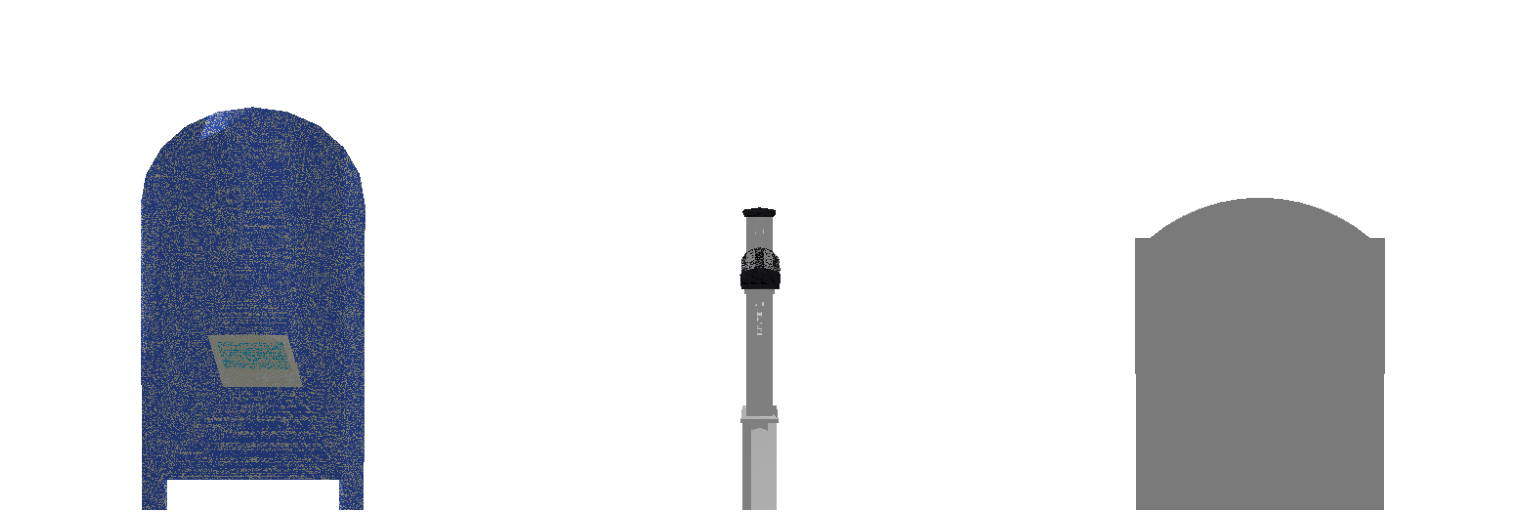

In [11]:
images_by_idxs = shapenet_dataset.render(
    idxs=list(range(3)),
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "faucet" and 3 models from the category "chair", we can do the following:

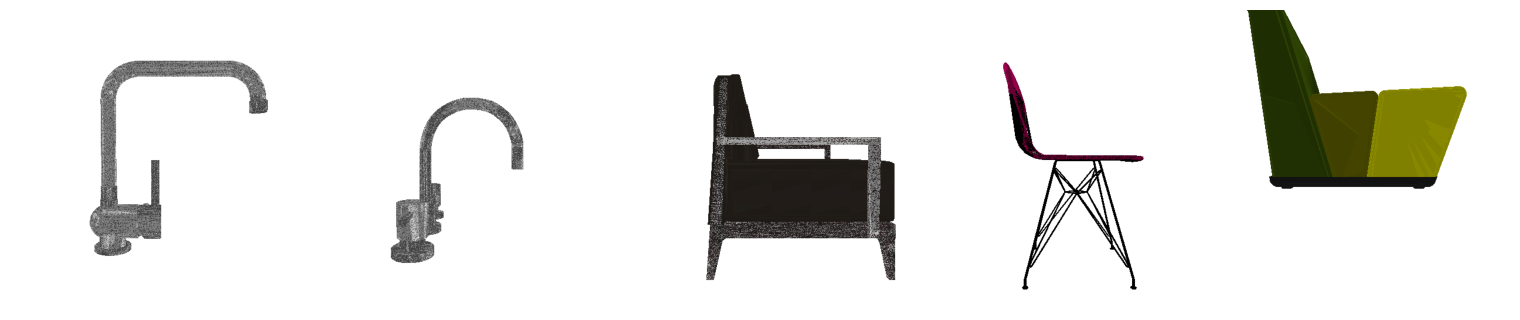

In [16]:
images_by_categories = shapenet_dataset.render(
    categories=["faucet", "chair"],
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

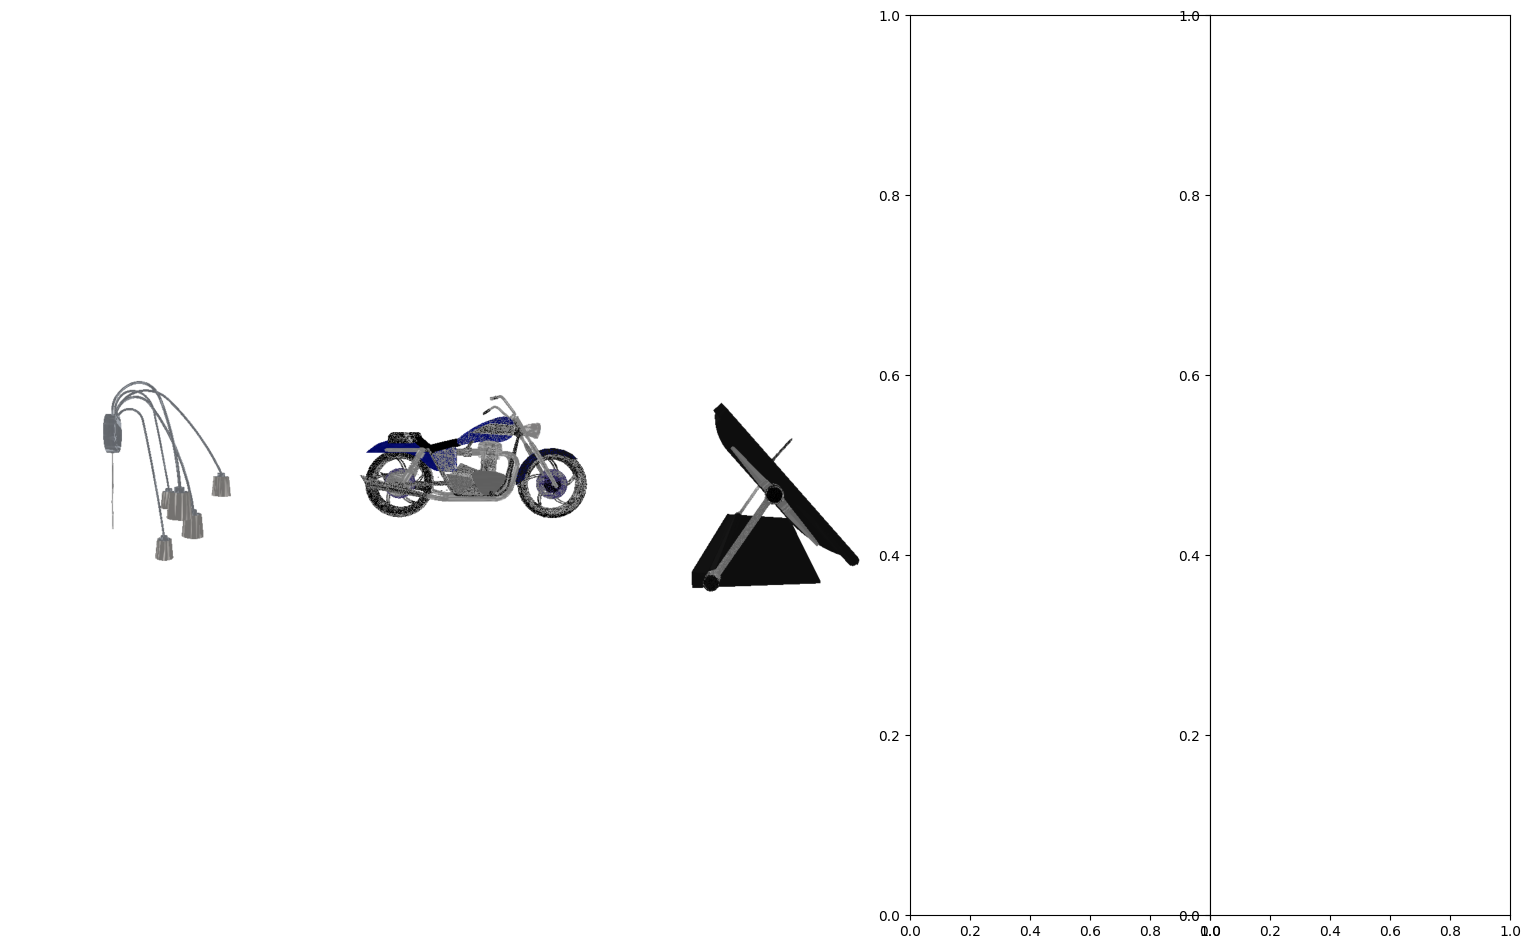

In [18]:
random_model_images = shapenet_dataset.render(
    sample_nums=[3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

In [68]:


# get a model from the dataset
model = shapenet_dataset[0]

# create a Meshes object from the model's vertices and faces
mesh = Meshes(verts=[torch.Tensor(model['verts'])], 
              faces=[torch.Tensor(model['faces']).int()])

# visualize the mesh
fig = plt.figure(figsize=(10, 10))
plot_meshes(mesh, fig=fig)

NameError: name 'plt' is not defined